## Задача понижения размерности данных

Что такое изображение?

![img](https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg)

Формально, просто набор чисел, например, картинка сверху - это матрица 500х750:

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

url = 'https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg'

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
print(np.array(img).shape)
np.array(img)

(500, 750)


array([[145, 145, 144, ..., 142, 143, 144],
       [146, 146, 146, ..., 141, 143, 144],
       [146, 147, 146, ..., 140, 142, 143],
       ...,
       [114, 111, 120, ...,  78,  69,  56],
       [ 75,  83, 104, ...,  53,  51,  64],
       [ 63,  82, 108, ..., 101,  95,  94]], dtype=uint8)

Что если взять случайную точку в пространстве 500*750? Будет ли это какое-то осмысленное изображение? Проверим

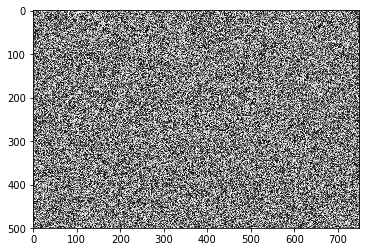

In [2]:
sample_img = np.random.choice(np.arange(256), size=500*750).reshape(500, 750)
plt.imshow(sample_img, cmap='gray')
plt.show()

Вероятно, что осмысленные изображение занимают лишь небольшую долю среди всевозможных числовых матриц? Как описать это подмножество (хотя бы его часть)?

Будем тренироваться строить описание на основе датасете MNIST:

In [3]:
from sklearn.datasets import fetch_openml
digits = fetch_openml('mnist_784')
digits.data.shape

(70000, 784)

In [4]:
images = digits.data.reshape(-1, 28, 28)

In [5]:
digits.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Пример картинки из датасета:

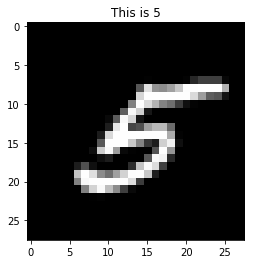

In [6]:
i = 985
plt.imshow(images[i], cmap='gray')
plt.title('This is {}'.format(digits.target[i]))
plt.show()

Воспользуемся моделью PCA:

![img](https://i.stack.imgur.com/G7Gkv.png)

Намопним, PCA ищет подпространство меньшей (но заданной) размерности, проекция на которое максимизирует дисперсию или, что то же самое, минимизирует суммарную ошибку:

![img](http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png)

Детальное изложение с формулами здесь https://www.csd.uwo.ca/~oveksler/Courses/CS434a_541a/Lecture7.pdf

Пример применение модели PCA (что здесь происходит?):

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

X_transformed = pca.fit_transform(digits.data.astype(float))
X_transformed.shape

(70000, 50)

Дисперсии вдоль главных компонент:

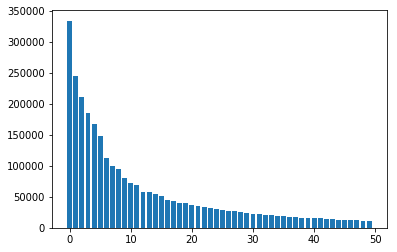

In [8]:
plt.bar(np.arange(50), pca.explained_variance_)
plt.show()

А вот как распределен датасет MNIST в пространстве первых двух главных компонент (разные цвета означают разные цифры на картинках):

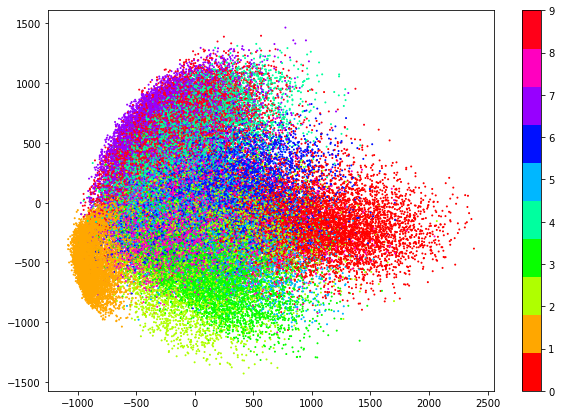

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Разберем, что стоит за операцией transform. Это всего лишь операция проектирования в новый базис:

In [10]:
proj = np.dot(digits.data.astype(float) - pca.mean_, pca.components_.T)
proj.shape

(70000, 50)

И мы получаем ту же самую картинку:

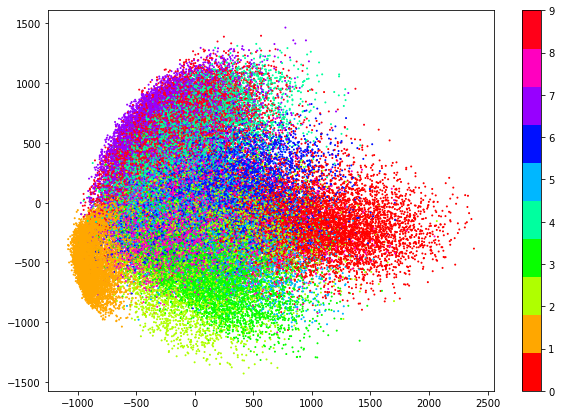

In [11]:
plt.figure(figsize=(10, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Картинка в 3D:

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X_transformed.T[:3], c=digits.target.astype(int), cmap='hsv')
plt.show()

Теперь выполним обратное преобразование:

In [13]:
X_restored = pca.inverse_transform(X_transformed)
X_restored.shape

(70000, 784)

Слева оригинал, справа - изображение, восстановленное из проекции

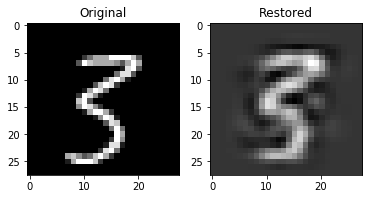

In [14]:
%matplotlib inline
i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(X_restored[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 1
Выпишите явное линейное преобразование, которое отображает точку из подространства главных компонент в исходное пространство (заполните ??? так, чтобы результат совпал с результатом в предыдущей ячейке)

Обоснование: когда уменьшали размерность, мы сначала вычитали матожидание, затем в качестве базиса брали 50 собственных векторов и переводили их в стандартный базис. В X_transformed мы имеем координаты в стандартном базисе, которые нам теперь нужно обратно перевести. Необходимо умножить i координату вектора на i собственный вектор, чтобы вернуться обратно. pca.components - эти координаты собственных векторов по строкам.
Чтобы найти i координату в первоначальном пространстве мы должны скалярно перемножить все текущие координаты на i столбец pca.components_, потому что именно он содержит информацию о i координате собственных векторов в первоначальном пространстве. 
np.dot(X_transformed, pca.components_[:,i]) - это формула для вычисления i координаты точек(Матрица 40000 1).

**Тогда np.dot(X_transformed, pca.components_) - необходимая формула для вычисления всех координат**

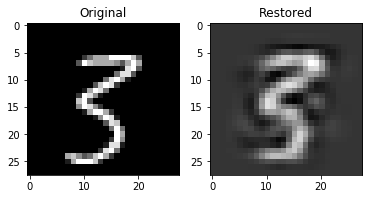

In [15]:
res = np.dot(X_transformed, pca.components_) + pca.mean_

i = 540
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(res[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 2

Определите, сколько нужно взять главных компонент, чтобы объяснить  99%, 95%, 90%, и 85% исходной дисперсии.

### Задача 3

Нарисуйте пример исходного изображения и результат восстановления из числа компонент, которое вы нашли в предыдущей задаче.

![img](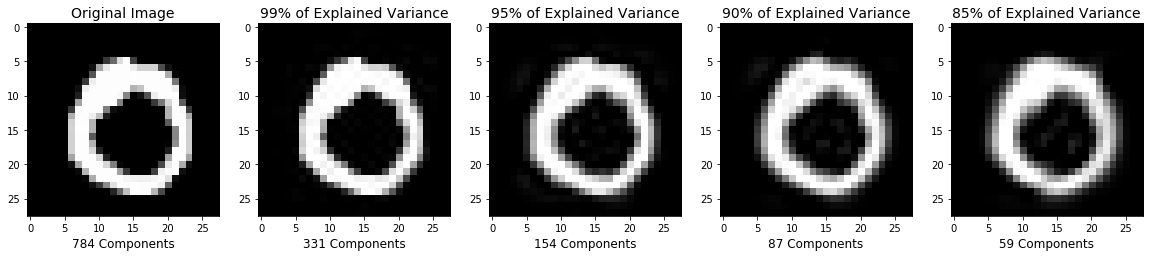%0A)

### Задача 4

Предложите способ генерации новых изображений с числами и приведите примеры сгенерированных картинок.

### Задача 5 (факультатив)
Можно ли построить представления датасета MNIST в 2D с более выраженным разделением кластеров отдельных цифр? For inspiration see https://colah.github.io/posts/2014-10-Visualizing-MNIST/

### Задача 2 и 3:

В качестве n_components для функции PCA возьмем необходимый процент дисперсии, поделённый на 100. Тогда n_components будет равна минимальному числу главных компонент.

In [16]:
pca99=PCA(n_components=0.99,svd_solver='full')
pca95=PCA(n_components=0.95,svd_solver='full')
pca90=PCA(n_components=0.90,svd_solver='full')
pca85=PCA(n_components=0.85,svd_solver='full')


In [17]:
X99 = pca99.fit_transform(digits.data.astype(float))
X99_ = pca99.inverse_transform(X99)
X95 = pca95.fit_transform(digits.data.astype(float))
X95_ = pca95.inverse_transform(X95)
X90 = pca90.fit_transform(digits.data.astype(float))
X90_ = pca90.inverse_transform(X90)
X85 = pca85.fit_transform(digits.data.astype(float))
X85_ = pca85.inverse_transform(X85)

In [18]:
print("Количество необходимых главных компонент соответственно равно:",pca99.n_components_,pca95.n_components_,pca90.n_components_,pca85.n_components_)

Количество необходимых главных компонент соответственно равно: 331 154 87 59


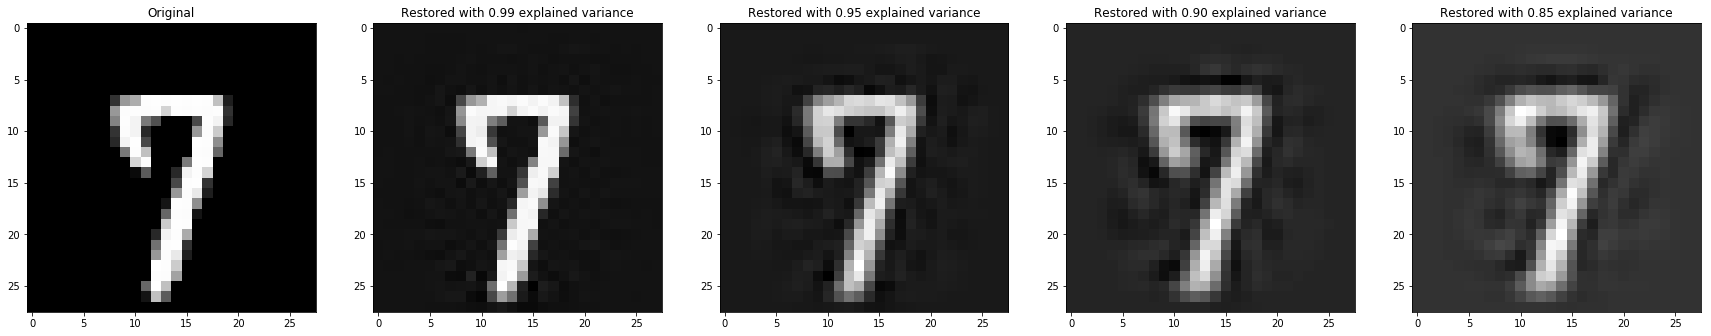

In [19]:
i = 888
fig, ax = plt.subplots(1, 5,figsize=(30, 15))
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(X99_[i].reshape(28, 28), cmap='gray')
ax[2].imshow(X95_[i].reshape(28, 28), cmap='gray')
ax[3].imshow(X90_[i].reshape(28, 28), cmap='gray')
ax[4].imshow(X85_[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored with 0.99 explained variance')
ax[2].set_title('Restored with 0.95 explained variance')
ax[3].set_title('Restored with 0.90 explained variance')
ax[4].set_title('Restored with 0.85 explained variance')
plt.show()

### Задача 4:

Преобразуем существующие картинки с числами, чтобы сгенерировать новые изображения

In [116]:
def pic_transf(im):
    image1=np.zeros([28,28],dtype=float)
    for i in range(1,28):
        for j in range (1,28):
            if (im[i,j]<1.):
                cur=im[i-1:i+2,j-1:j+2].mean() #Рассматриваем окрестность точки
                if (cur>10.0): #Случай, когда точка близка к границам числа в исходном изображении
                    if np.random.choice([0,1])==0: #В половине случаев не будем ничего менять
                        image1[i,j]=im[i,j]
                    else: #Немного поменяем значение в точке. Можно сказать, что диапазон от нуля до с.ариф. по правилу трёх сигм
                        image1[i,j]=min(abs(np.random.normal(loc=im[i,j],scale=cur/3)),254.0)
                else: #Если вокруг пустота, то ничего менять не нужно
                    image1[i,j]=0
            else: #В точках, рассположенных по центру числа существенно менять ничего не будем, чтобы сохранить очертание.
                cur=im[i-1:i+2,j-1:j+2].reshape(9)
                cur.sort()
                cur=cur[-5:]
                d=abs((cur[0]-cur[4])/3) #Отклонение для главных точек получится небольшим. Снова правило трех сигм 
                image1[i,j]=min(abs(np.random.normal(loc=im[i,j],scale=d)),254.0)
    return image1
                    


In [117]:
imm1=pic_transf(images[888].reshape(28,28))
imm2=pic_transf(images[888].reshape(28,28))
imm3=pic_transf(images[888].reshape(28,28))

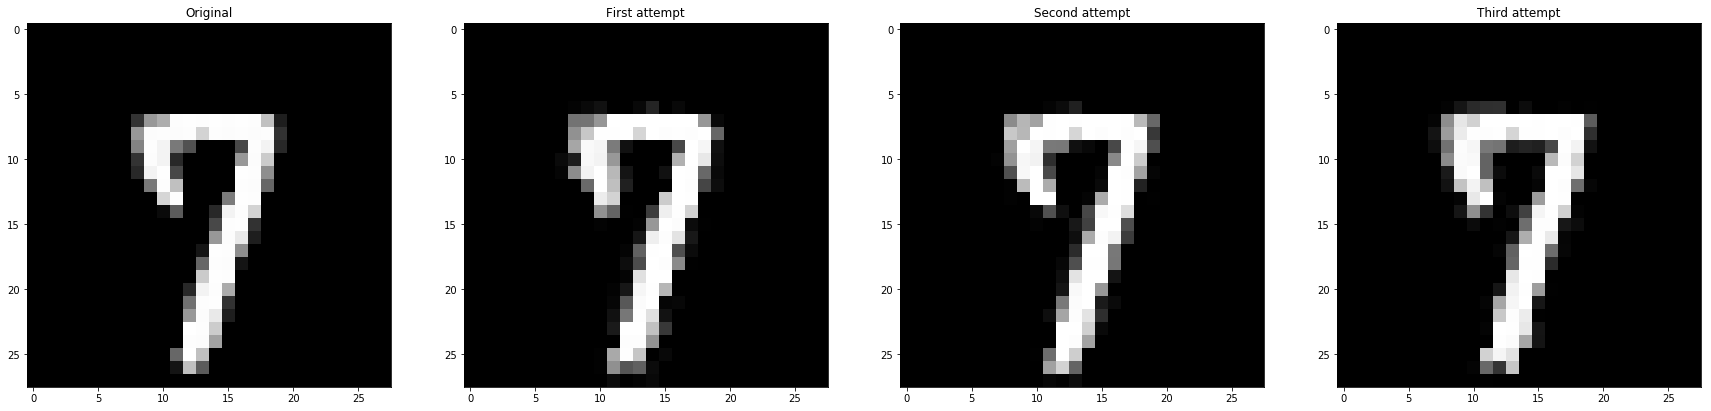

In [118]:
i = 888
fig, ax = plt.subplots(1, 4,figsize=(30, 15))
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(imm1, cmap='gray')
ax[2].imshow(imm2, cmap='gray')
ax[3].imshow(imm3, cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('First attempt')
ax[2].set_title('Second attempt')
ax[3].set_title('Third attempt')
plt.show()

In [122]:
imm1=pic_transf(images[777].reshape(28,28))
imm2=pic_transf(images[777].reshape(28,28))
imm3=pic_transf(images[777].reshape(28,28))

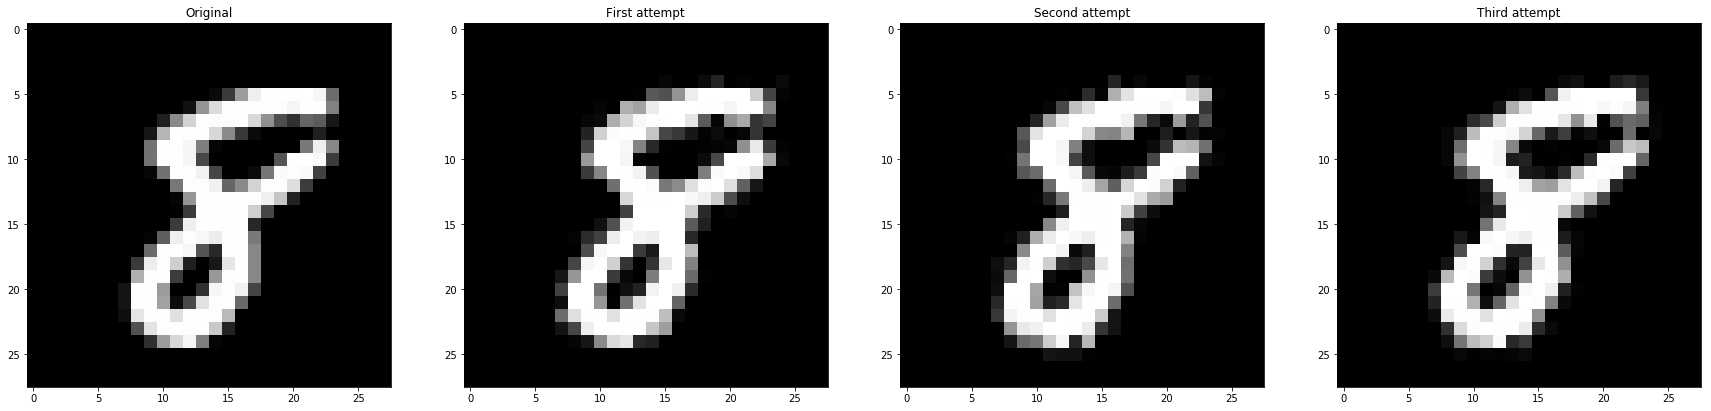

In [123]:
i = 777
fig, ax = plt.subplots(1, 4,figsize=(30, 15))
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(imm1, cmap='gray')
ax[2].imshow(imm2, cmap='gray')
ax[3].imshow(imm3, cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('First attempt')
ax[2].set_title('Second attempt')
ax[3].set_title('Third attempt')
plt.show()

### Таким образом, мы получили алгоритм, который немного видоизменяет границы. Этим способом можно генерировать новые картинки и быть уверенным в сохранении четкости определения числа (Не знаю, насколько такой способ полезен где-нибудь :-()  )